<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Recurrent%20Neural%20Networks%2C%20Time%20Series%2C%20and%20Sequence%20Data/PyTorch_SimpleRNN_Sine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

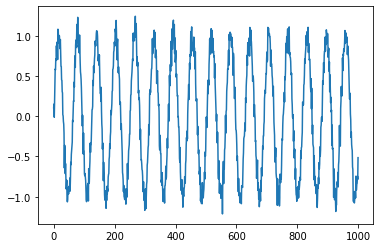

In [18]:
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

plt.plot(series)
plt.show()

In [33]:
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [35]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)

        self.rnn = nn.RNN(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            nonlinearity='relu',
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)

        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:, -1, :])
        return out

In [36]:
# instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [37]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [38]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [39]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [40]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Save the loss
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 10 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [41]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 10/200, Train Loss: 0.0641, Test Loss: 0.0412
Epoch 20/200, Train Loss: 0.0266, Test Loss: 0.0296
Epoch 30/200, Train Loss: 0.0270, Test Loss: 0.0292
Epoch 40/200, Train Loss: 0.0259, Test Loss: 0.0271
Epoch 50/200, Train Loss: 0.0236, Test Loss: 0.0252
Epoch 60/200, Train Loss: 0.0230, Test Loss: 0.0245
Epoch 70/200, Train Loss: 0.0224, Test Loss: 0.0242
Epoch 80/200, Train Loss: 0.0224, Test Loss: 0.0240
Epoch 90/200, Train Loss: 0.0223, Test Loss: 0.0239
Epoch 100/200, Train Loss: 0.0222, Test Loss: 0.0238
Epoch 110/200, Train Loss: 0.0222, Test Loss: 0.0238
Epoch 120/200, Train Loss: 0.0221, Test Loss: 0.0237
Epoch 130/200, Train Loss: 0.0220, Test Loss: 0.0236
Epoch 140/200, Train Loss: 0.0219, Test Loss: 0.0235
Epoch 150/200, Train Loss: 0.0218, Test Loss: 0.0234
Epoch 160/200, Train Loss: 0.0217, Test Loss: 0.0232
Epoch 170/200, Train Loss: 0.0215, Test Loss: 0.0229
Epoch 180/200, Train Loss: 0.0212, Test Loss: 0.0227
Epoch 190/200, Train Loss: 0.0207, Test Loss: 0.0222
Ep

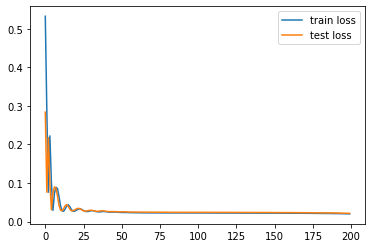

In [42]:
# plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [43]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

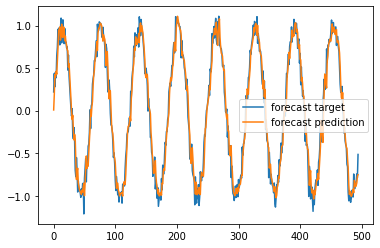

In [44]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [45]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_) # [0, 0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

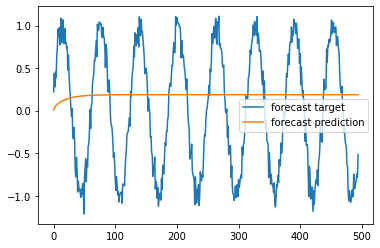

In [46]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()